In [1]:
import cv2
import numpy as np
from math import *
from skimage import io
from matplotlib import pyplot as plt

In [2]:
path = './input/task1/'

def imshow(img, f_size=(20,20)):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=f_size)
    plt.imshow(img)


### Find ellipse by 7 points

[[ 1.00000000e+00 -1.22400765e-01 -4.41972210e+02]
 [-1.22400765e-01  7.09191119e+00 -2.84038921e+03]
 [-4.41972210e+02 -2.84038921e+03  1.36339271e+06]]
Ellipse 
[[50.1080413]]
[[-116.99297683]]
[[-40.8818856]]
[[-31.52652348]]
[[153.51561858]]
[[-133.47159871]]
[[119.30395188]]
u =  [[-3.24168765e-04  6.51707943e-01  7.58469941e-01]
 [-2.08332125e-03 -7.58468775e-01  6.51706051e-01]
 [ 9.99997777e-01 -1.36887380e-03  1.60358889e-03]]
m1v.T =  [[-3.24168765e-04  6.51707943e-01  7.58469941e-01]
 [-2.08332125e-03 -7.58468775e-01  6.51706051e-01]
 [ 9.99997777e-01 -1.36887380e-03  1.60358889e-03]]
v =  [[-3.24168765e-04 -2.08332125e-03  9.99997777e-01]
 [ 6.51707943e-01 -7.58468775e-01 -1.36887380e-03]
 [-7.58469941e-01 -6.51706051e-01 -1.60358889e-03]]
usv =  [[ 1.00000000e+00 -1.22400765e-01 -4.41972210e+02]
 [-1.22400765e-01  7.09191119e+00 -2.84038921e+03]
 [-4.41972210e+02 -2.84038921e+03  1.36339271e+06]]


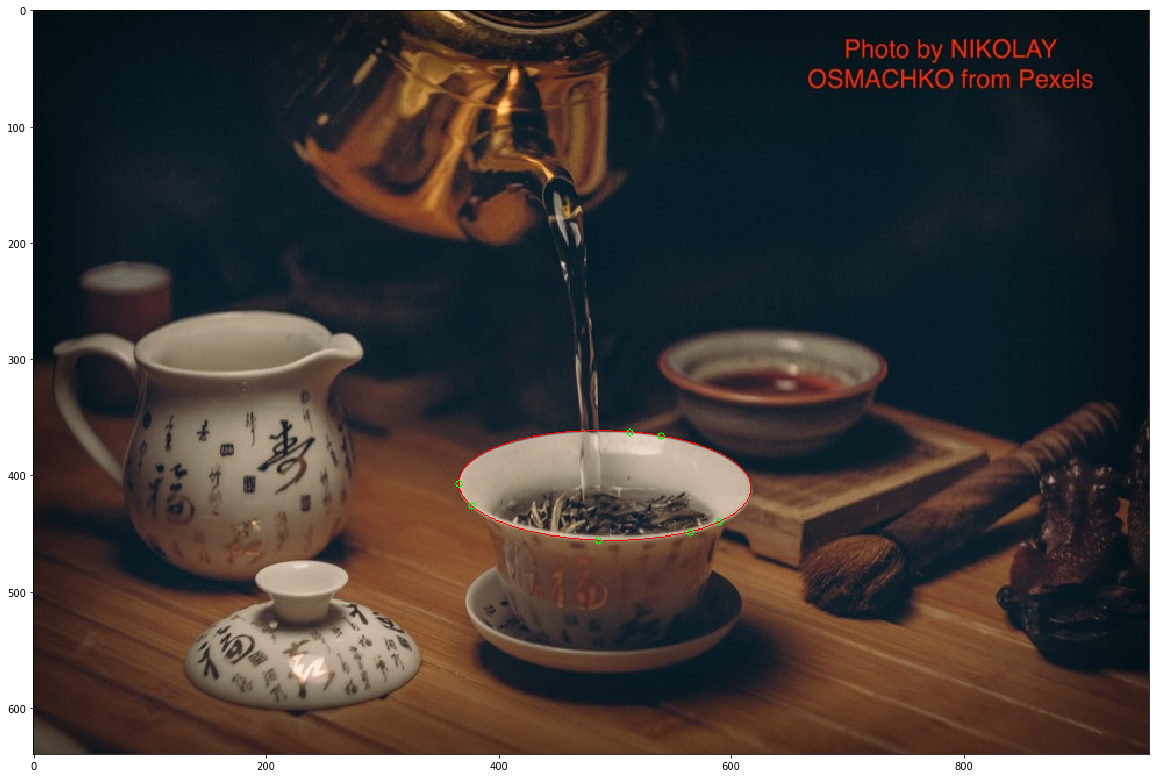

In [3]:
imgc = cv2.imread(path + 'ellipse.jpg')

img = imgc.copy()

points = np.array([ [366, 407], [513, 363], [377, 426], [486, 456], [565, 449], [590, 440], [540, 366] ], np.double)

m = np.zeros((len(points) ,6))

for k in range(0, len(points)):
    m[k][0] = points[k][0]**2
    m[k][1] = 2*points[k][0]*points[k][1]
    m[k][2] = points[k][1]*points[k][1]
    m[k][3] = 2*points[k][0]
    m[k][4] = 2*points[k][1]
    m[k][5] = 1

mu, ms, mv = np.linalg.svd(m)

R = mv[5, :]
R /= R[0]

E = np.array(
      [[ R[0], R[1], R[3]],
      [R[1], R[2], R[4]],
      [R[3], R[4], R[5]] ], np.double )

print(E)

print( "Ellipse " if E[0,0]*E[1,1]>E[0,1]*E[1,0] else "Not Ellipse!!!")

# result on given points:
for k in range(0, len(points)):
    print( np.matmul( np.matmul( [ [points[k][0], points[k][1], 1] ], E ), [[points[k][0]],[points[k][1]],[1]] ) )

    
#find circle->ellipse conversion
u, s, v = np.linalg.svd(E)
u2 = np.matmul(u, np.diag(np.sqrt(s)) )
H = np.linalg.inv( u2.T)

print( "u = ", u )
print( "m1v.T = ", np.matmul(np.diag([1,1,-1]),  v ).T)

print( "v = ", v )
print( "usv = ", np.matmul(np.matmul(u, np.diag(s)), v) )


# draw ellipse
for alpha in range(0,360):
    a1 = np.matmul( H, [[sin(pi*alpha/180)], [cos(pi*alpha/180)], [1]] )
    a1 = (a1/a1[2])
    a2 = np.matmul( H, [[sin(pi*(alpha+1)/180)], [cos(pi*(alpha+1)/180)], [1]] )
    a2 = (a2/a2[2])
    cv2.line(img, (a1[0],a1[1]),(a2[0],a2[1]),(0,0,255), 1)

for k in range(0, len(points)):
    cv2.circle(img, (int(points[k][0]),int(points[k][1])),3,(0,255,0))

imshow(img)

### Build a plot of dependency of max deviation from grand truth ellipse and level of noise in the points.

In [4]:
# build ellipse by points
def find_ellipse(points):
    m = np.zeros((len(points) ,6))

    for k in range(0, len(points)):
        m[k][0] = points[k][0]**2
        m[k][1] = 2*points[k][0]*points[k][1]
        m[k][2] = points[k][1]*points[k][1]
        m[k][3] = 2*points[k][0]
        m[k][4] = 2*points[k][1]
        m[k][5] = 1

    mu, ms, mv = np.linalg.svd(m)

    R = mv[5, :]
    R /= R[0]

    E = np.array(
          [[ R[0], R[1], R[3]],
          [R[1], R[2], R[4]],
          [R[3], R[4], R[5]] ], np.double )
    
    u, s, v = np.linalg.svd(E)
    u2 = np.matmul(u, np.diag(np.sqrt(s)) )
    H = np.linalg.inv( u2.T)
    
    return H

In [5]:
# find max deviation between two ellipses
def max_deviation(H1, H2):
    max_dev = 0
    
    for alpha in range(0,360):
        a1 = np.matmul( H1, [[sin(pi*alpha/180)], [cos(pi*alpha/180)], [1]] )
        a1 = (a1/a1[2])
        
        a2 = np.matmul( H2, [[sin(pi*alpha/180)], [cos(pi*alpha/180)], [1]] )
        a2 = (a2/a2[2])
        
        max_dev = max(max_dev, np.linalg.norm(a1-a2))
    
    return max_dev

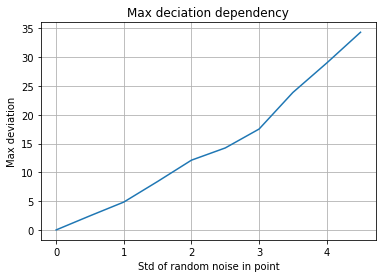

In [6]:
np.random.seed(1000)

data = [[], []]

true_H = find_ellipse(points)

N = 100

for sigma in np.arange(0,5,0.5):    
    noize_points = np.zeros(points.shape, np.double)
    
    results = []
    for n in range(N):    
        # generate random noise
        for (i, p) in enumerate(points):
            noize_points[i][0] = np.random.normal(p[0], sigma, 1)[0]
            noize_points[i][1] = np.random.normal(p[1], sigma, 1)[0]

        # find ellipse by random noise points
        noise_H = find_ellipse(noize_points)

        # find max deviation between ellipses
        result = max_deviation(true_H, noise_H)
        results.append(result)
    
    data[0].append(sigma)
    data[1].append(np.mean(results))

    
# plot results
plt.title('Max deciation dependency')
plt.xlabel('Std of random noise in point')
plt.ylabel('Max deviation')
plt.grid(True)
plt.plot(data[0], data[1])
plt.show()
    